In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoo_fin import stock_info as y_fin
import json
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

# Charting

In [2]:
def drawLine2P(x,y,xlims):
    xrange = np.arange(xlims[0],xlims[1],1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return [xrange, k*xrange + b]

In [3]:
def PlotTimeSeries(ticker, years_ago=5, months_ago=0):
    #closeHist = pd.DataFrame(FinDB[ticker]['stockHist']['Close']).rename({'Close':'Price'}, axis=1)
    try:
        closeHist = pd.DataFrame(yf.download(ticker,
                                             period='max', 
                                             progress=False)['Close']).rename({'Close':'Price'}, axis=1)
        #closeHist = pd.DataFrame(yf.Ticker(ticker).history(period='max')['Close']).rename({'Close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    except json.JSONDecodeError:
        closeHist = pd.DataFrame(y_fin.get_data(ticker)['close']).rename({'close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    closeHist = closeHist[closeHist.index > dt.datetime.now() + relativedelta(years=-years_ago)]
    closeHist.reset_index(inplace=True)
    closeHist['Month'] = closeHist.Date.apply(lambda x: dt.date(x.year, x.month, 1))
    closeHist = closeHist.groupby('Month').last().rename({'Price':'Price(Monthly avg.)'}, axis=1)
    closeHist['x_index'] = pd.Series(range(len(closeHist.index)), closeHist.index)
    MinSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) > closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) > closeHist['Price(Monthly avg.)'])]
    MaxSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) < closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) < closeHist['Price(Monthly avg.)'])]
    BothSeries = pd.concat([MinSeries, MaxSeries]).sort_index()
    MaxMaxSeries = BothSeries[(BothSeries.shift(1) < BothSeries) & (BothSeries.shift(-1) < BothSeries)]
    MinMinSeries = BothSeries[(BothSeries.shift(1) > BothSeries) & (BothSeries.shift(-1) > BothSeries)]
    #3PTL Buy Line
    X = list()
    Y = list()
    x_1_date = MaxSeries.idxmax()
    x_1 = closeHist[closeHist.index==x_1_date].x_index.iloc[0]
    X.append(x_1)
    Y.append(MaxSeries.max())
    try:
        x_2_date = MaxSeries[MaxSeries.index > x_1_date].idxmax()
        x_2 = closeHist[closeHist.index==x_2_date].x_index.iloc[0]
        X.append(x_2)
        Y.append(MaxSeries[MaxSeries.index > x_1_date].max())
    except ValueError:
        pass
    #3PTL Sell Line
    X2 = list()
    Y2 = list()
    x2_1_date = MinSeries.idxmin()
    x2_1 = closeHist[closeHist.index==x2_1_date].x_index.iloc[0]
    X2.append(x2_1)
    Y2.append(MinSeries.min())
    try:
        x2_2_date = MinSeries[MinSeries.index > x2_1_date].idxmin()
        x2_2 = closeHist[closeHist.index==x2_2_date].x_index.iloc[0]
        X2.append(x2_2)
        Y2.append(MinSeries[MinSeries.index > x2_1_date].min())
    except ValueError:
        pass
    
    print('Current Price for', ticker, 'is', str(round(closeHist['Price(Monthly avg.)'].iloc[-1], 2)))
    
    plt.figure(figsize=[20,9])
    with plt.style.context('fivethirtyeight'):
        plt.plot(closeHist['Price(Monthly avg.)'], zorder=0)
        if len(X) < 2:
            pass
        else: 
            ThreePtB = drawLine2P(x=X,y=Y,xlims=[closeHist['x_index'].values.min(),
                                      closeHist['x_index'].values.max()+1])
            buyPrice = round(ThreePtB[1][-1], 2)
            if buyPrice < 0:
                buyPrice = round(0.00, 2)
            print('Buy Price for', ticker, 'is', buyPrice)
            plt.plot(closeHist.index, ThreePtB[1],
                     c='g', linestyle='dashed')
            
        if len(X2) < 2:
            pass
        else: 
            ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                      closeHist['x_index'].values.max()+1])
            sellPrice = round(ThreePtS[1][-1], 2)
            if sellPrice < 0:
                sellPrice = round(0.00, 2)            
            print('Sell Price for', ticker, 'is', round(ThreePtS[1][-1], 2))
            plt.plot(closeHist.index, ThreePtS[1],
                     c='r', linestyle='dashed')
            
        plt.scatter(MinSeries.index, 
                    MinSeries,
                    c='r', s=50, zorder=10)
        plt.scatter(MaxSeries.index, 
                    MaxSeries,
                    c='g', s=50, zorder=10)
        plt.scatter(MaxMaxSeries.index, 
                    MaxMaxSeries,
                    c='y', s=100, zorder=5)
        plt.scatter(MinMinSeries.index, 
                    MinMinSeries,
                    c='y', s=100, zorder=5)
    plt.legend([closeHist.columns[0]])
    plt.autoscale()
    plt.show()

In [4]:
def Chart3PTL(tickerListing, years=5, mos=0):
    List = tickerListing.split()
    for i in List:
        print(i)
        PlotTimeSeries(i, years, mos)

FMG.AX
Current Price for FMG.AX is 15.41
Sell Price for FMG.AX is 18.6


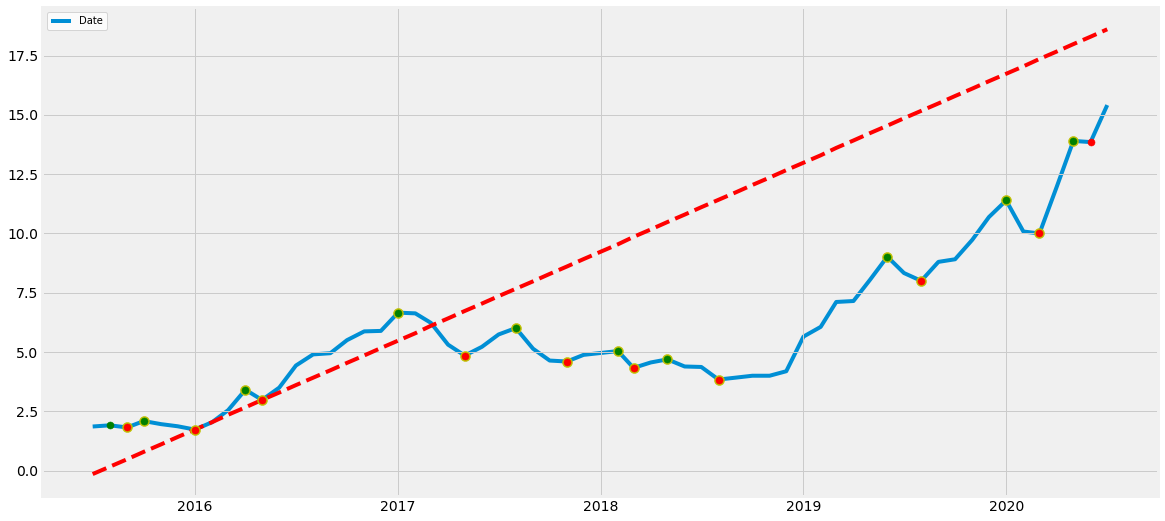

RMS.AX
Current Price for RMS.AX is 1.94
Sell Price for RMS.AX is 2.04


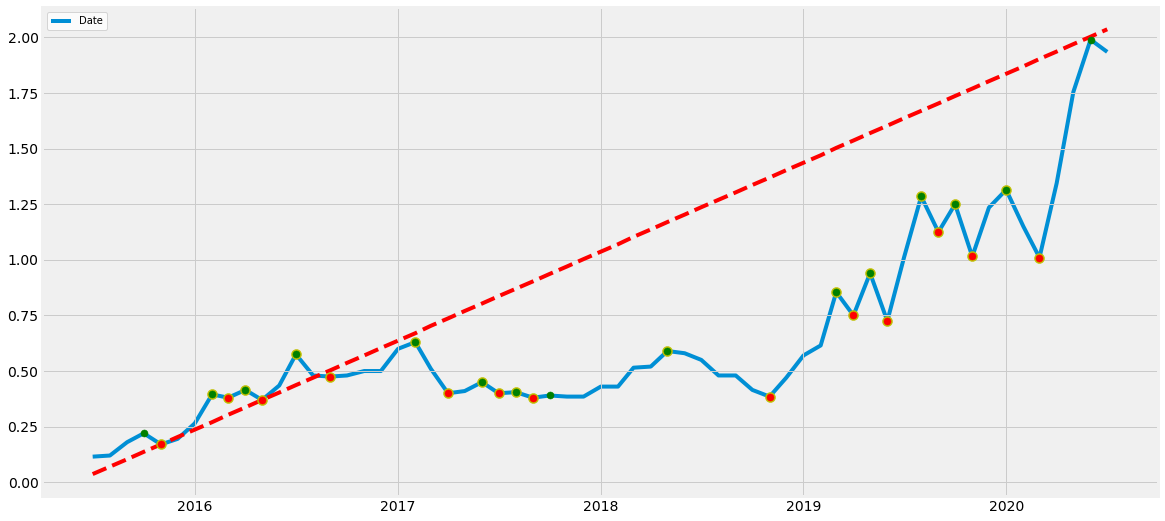

SFC.AX
Current Price for SFC.AX is 12.1
Buy Price for SFC.AX is 13.68
Sell Price for SFC.AX is 4.62


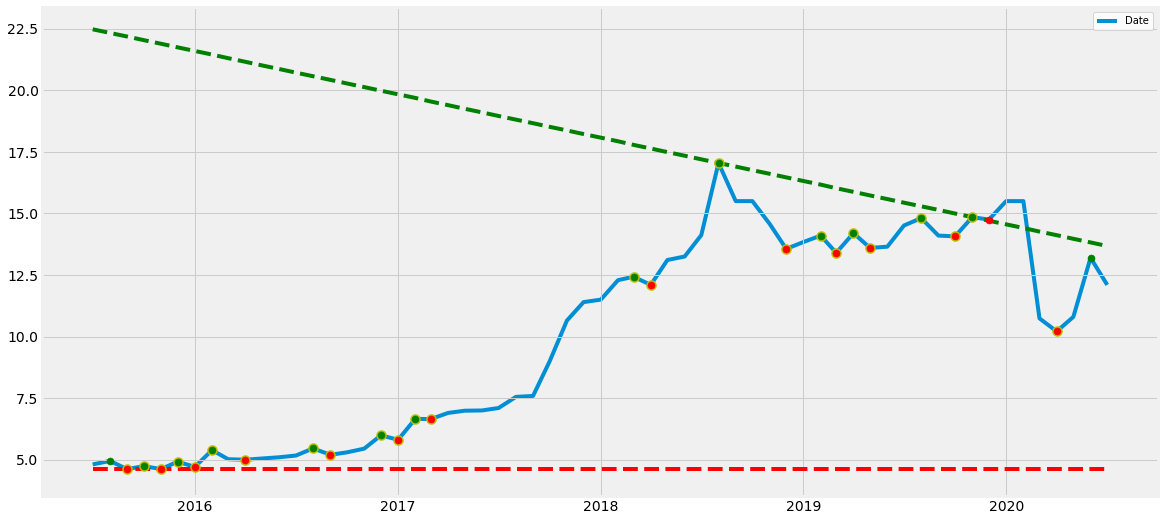

PRU.AX
Current Price for PRU.AX is 1.37
Sell Price for PRU.AX is 0.32


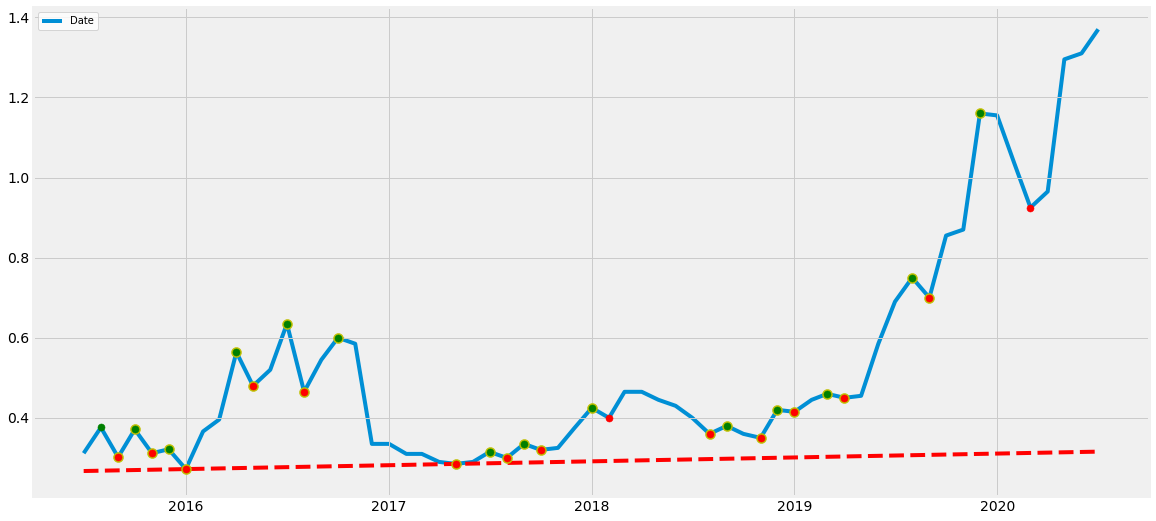

AQG.AX
Current Price for AQG.AX is 9.65
Buy Price for AQG.AX is 5.75
Sell Price for AQG.AX is 2.24


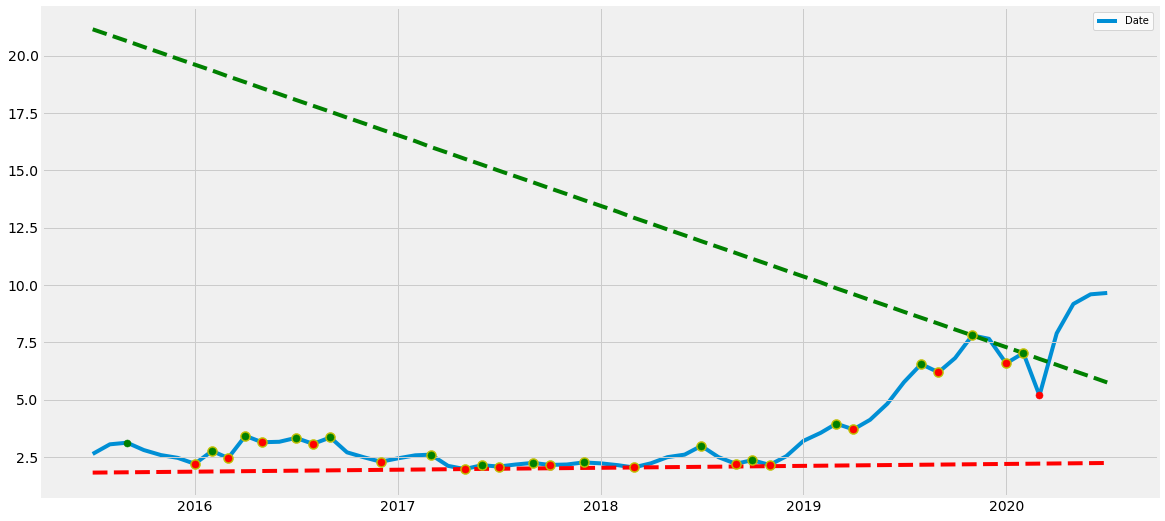

STO.AX
Current Price for STO.AX is 5.21
Buy Price for STO.AX is 3.7
Sell Price for STO.AX is 3.47


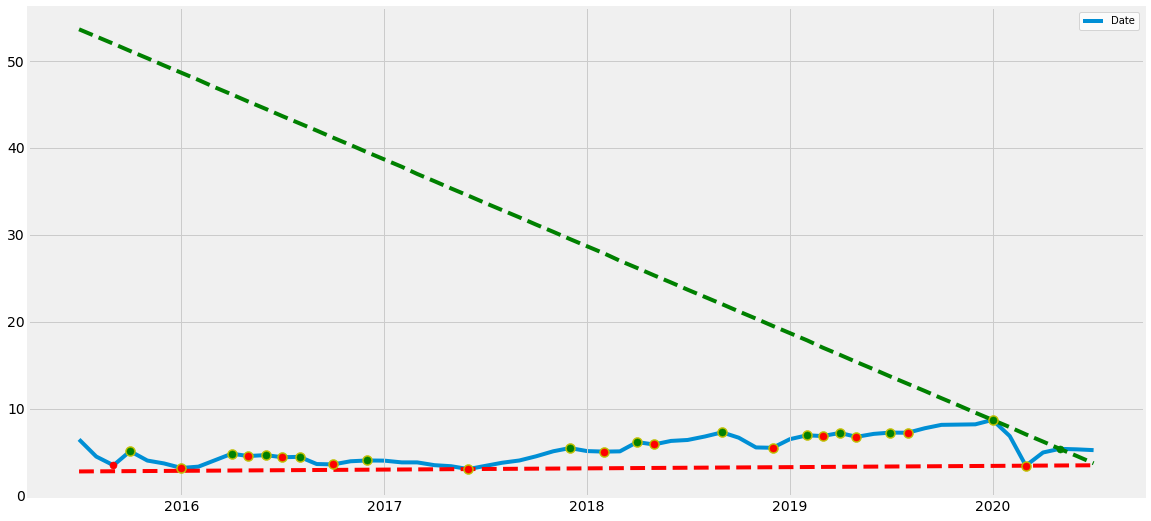

BFG.AX
Current Price for BFG.AX is 1.25
Sell Price for BFG.AX is 0.88


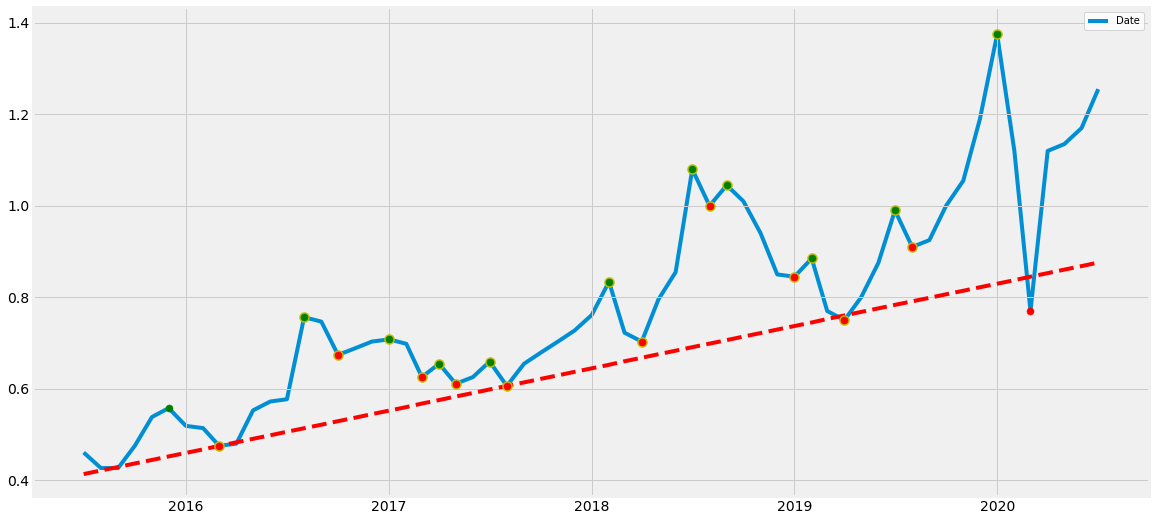

KOV.AX
Current Price for KOV.AX is 4.25
Buy Price for KOV.AX is 3.22
Sell Price for KOV.AX is 2.16


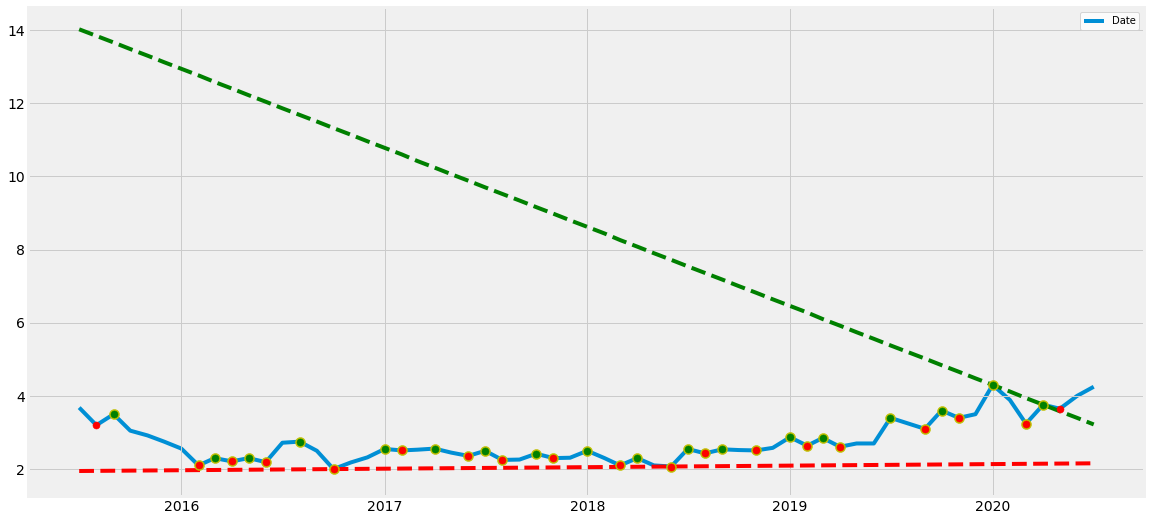

RRL.AX
Current Price for RRL.AX is 5.43
Buy Price for RRL.AX is 5.37
Sell Price for RRL.AX is 8.81


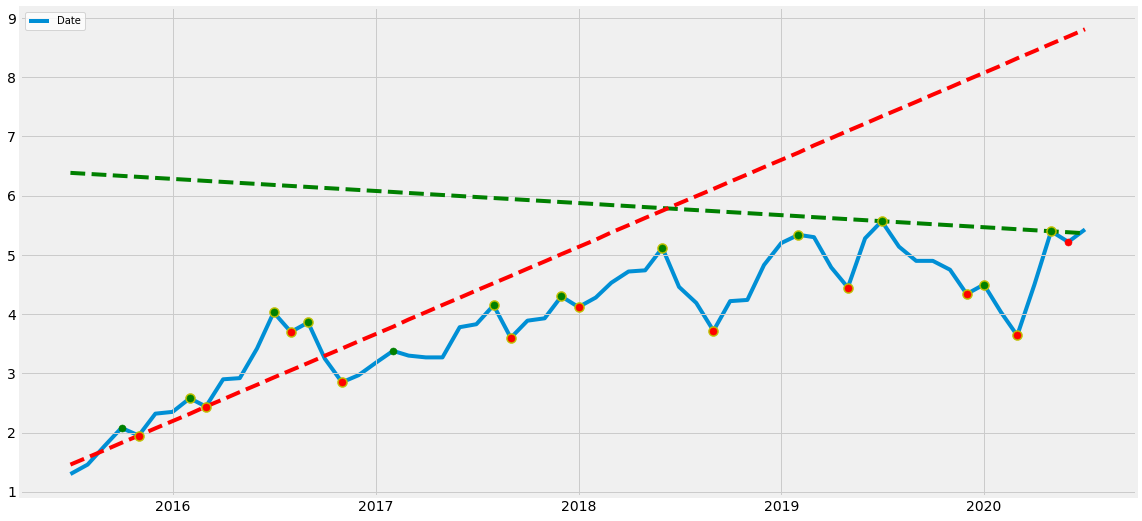

HAW.AX
Current Price for HAW.AX is 0.14
Sell Price for HAW.AX is 0.05


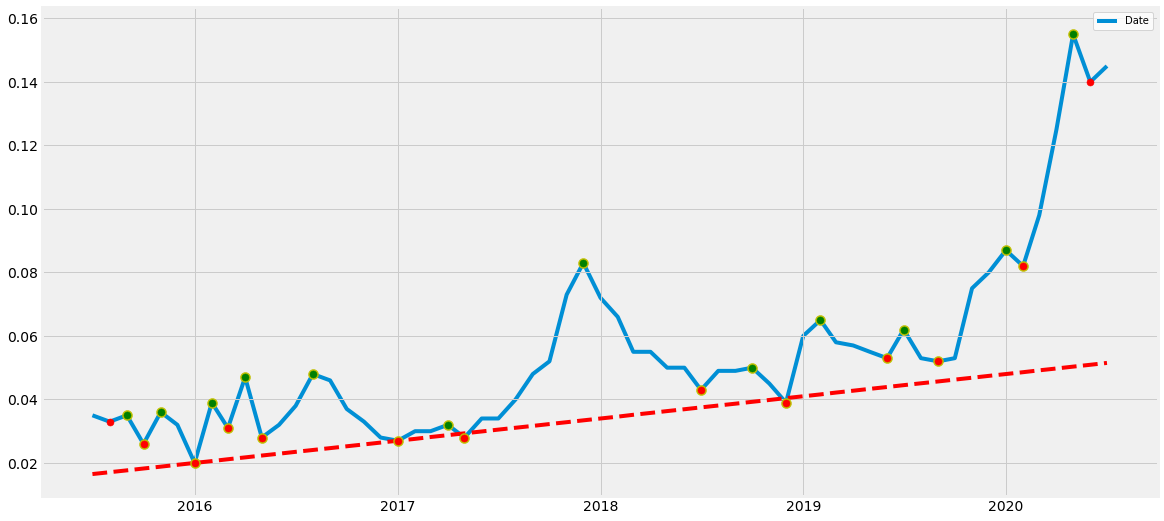

MRC.AX
Current Price for MRC.AX is 0.24
Buy Price for MRC.AX is 0.28
Sell Price for MRC.AX is 0.14


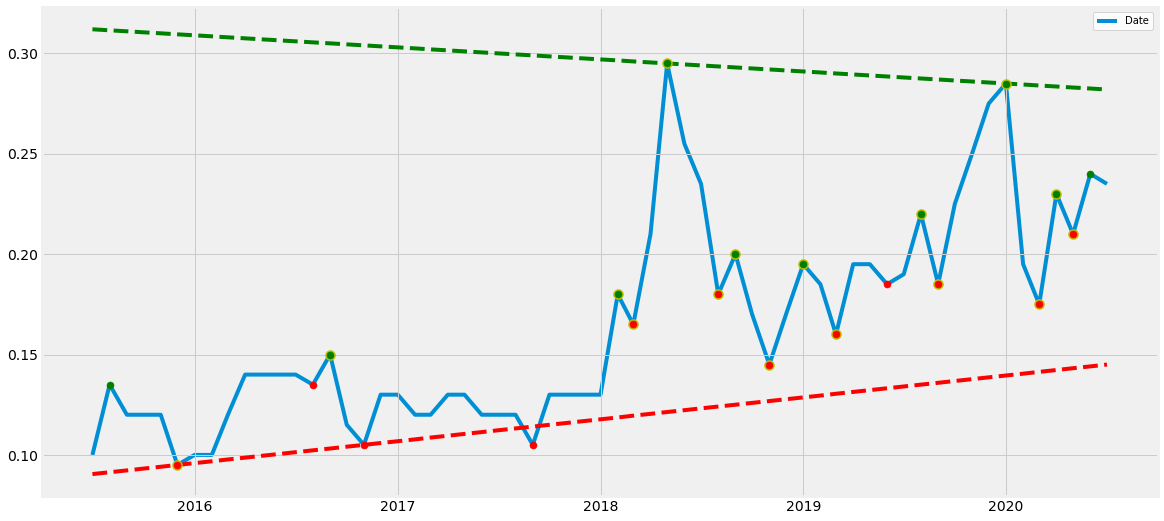

KRM.AX
Current Price for KRM.AX is 0.04
Buy Price for KRM.AX is 0.0


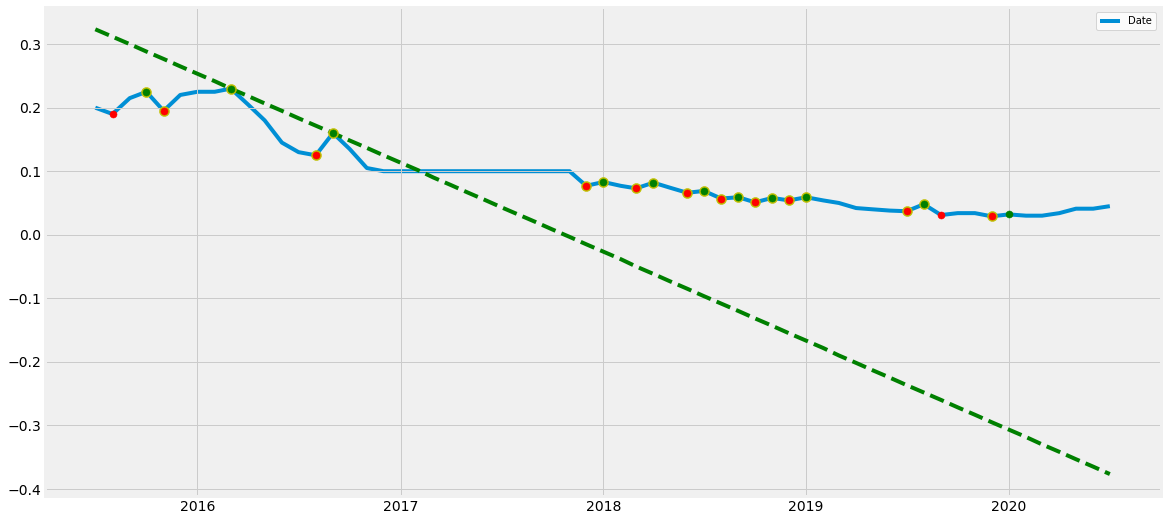

GEAR.AX
Current Price for GEAR.AX is 17.62


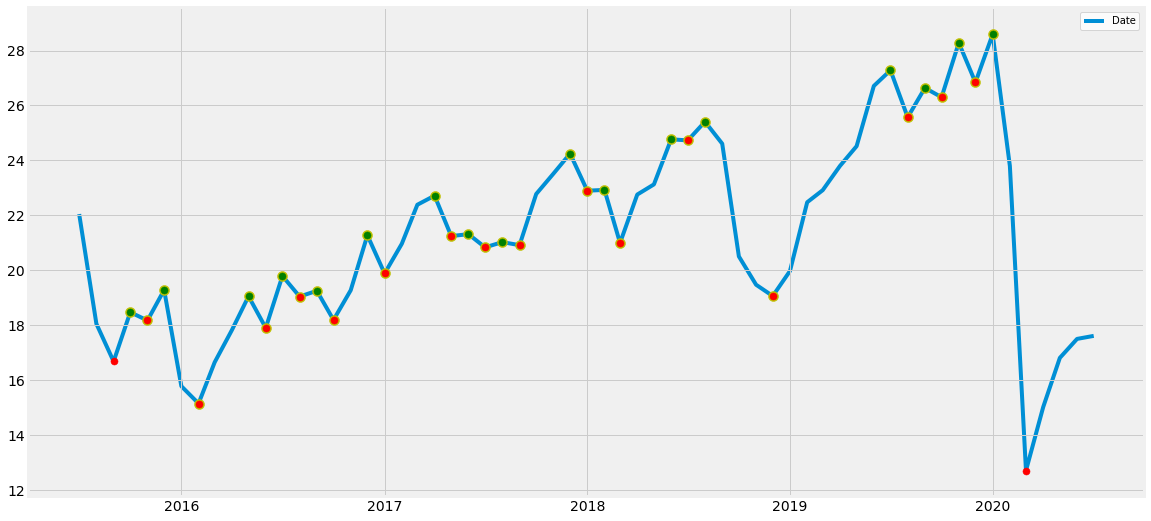

AGD.AX
Current Price for AGD.AX is 0.16
Buy Price for AGD.AX is 0.16
Sell Price for AGD.AX is 0.07


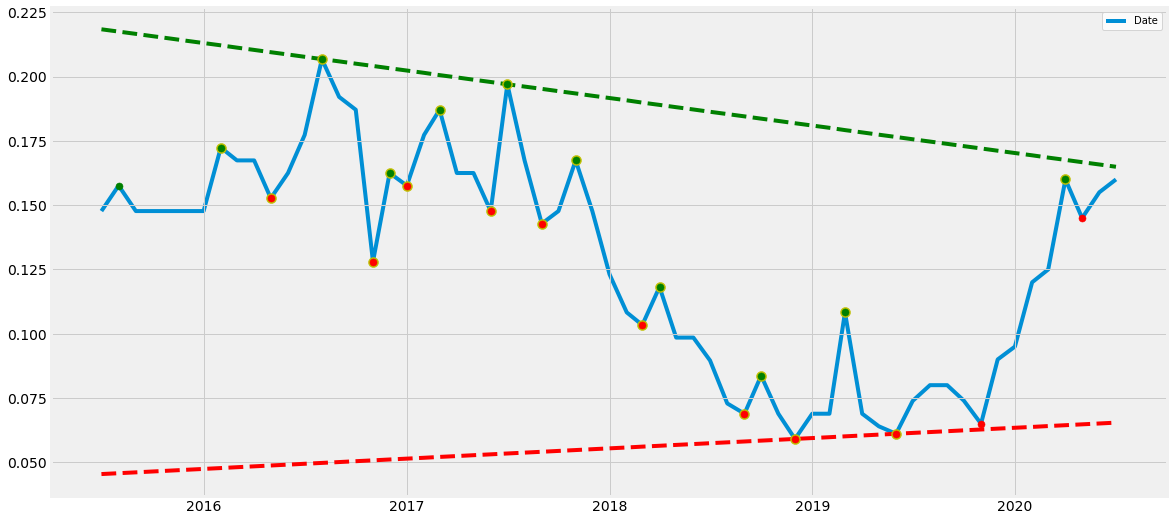

MML.AX
Current Price for MML.AX is 0.7
Buy Price for MML.AX is 0.67
Sell Price for MML.AX is 0.4


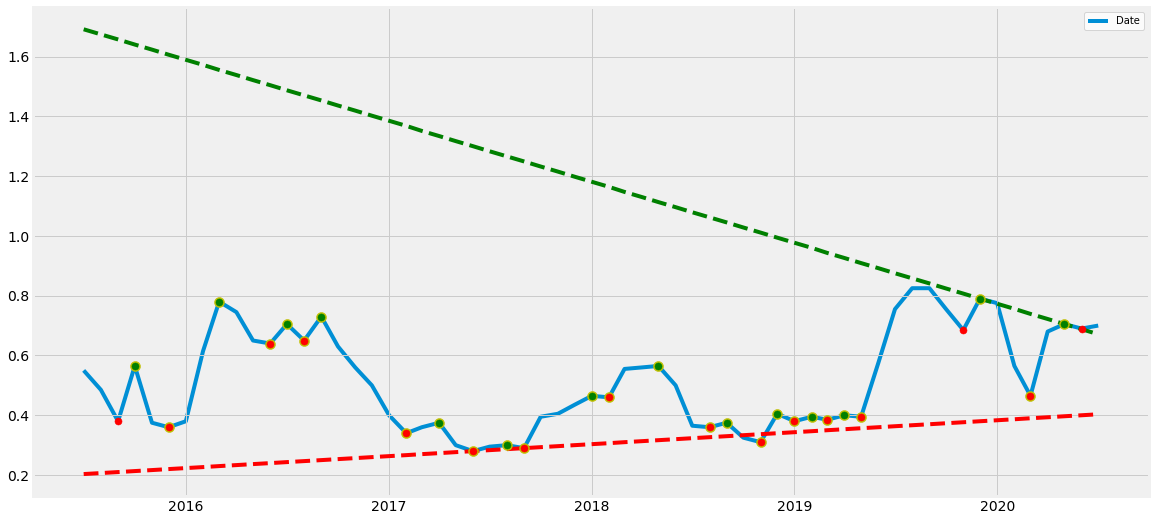

In [6]:
Chart3PTL("""FMG.AX
RMS.AX
SFC.AX
PRU.AX
AQG.AX
STO.AX
BFG.AX
KOV.AX
RRL.AX
HAW.AX
MRC.AX
KRM.AX
GEAR.AX
AGD.AX
MML.AX""")